In [3]:
cd SRS/

c:\Users\axel_\Documents\GITHUB REPOSITORIOS\ic_tps\SRS


In [4]:
import numpy as np
from srs import SRGA
from Evolutivo.evolutivo import GA
from tqdm import tqdm
from utils import fitness

n_bits = 30

# Alfa, Umbral, Phi(5), Psi(5)
var_bits = np.ones(12, dtype=int) * 30
var_lims = np.zeros(13, dtype=int)
var_lims[:-1] = np.arange(0, 12) * var_bits
var_lims[-1] = int(n_bits*12)
var_min  = np.array(
    [0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]
)
var_max  = np.array(
    [100, 1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
)

interrev = 1 * 24 * 3600
nvent = 5
ancho_ventanas = np.exp( np.log(15) / nvent * np.arange(1, nvent+1))
ancho_ventanas *= (24 * 3600)

In [5]:
def DecoDecimal(v, a=var_min, b=var_max):
    vs = []
    for i in range(len(var_lims)-1):
        vs.append(v[var_lims[i]:var_lims[i+1]])

    xs = []
    xs = np.zeros(a.size)

    for (i,vi) in enumerate(vs):
        k = len(vi)
        d = sum(2**(k-np.array(range(1,k+1)))*vi)
        xs[i] = a[i] + (d*((b[i]-a[i])/((2**k)-1)))

    return xs

In [6]:
cd ..

c:\Users\axel_\Documents\GITHUB REPOSITORIOS\ic_tps


In [7]:
#Cargar las matrices m_t, m_c, m_s y a lens
m_t = np.load('SRS/data/times.npy')
m_c = np.load('SRS/data/correct.npy')
m_s = np.load('SRS/data/seen.npy')
m_d = np.load('SRS/data/lexemes_dificulty.npy')
lens = np.load('SRS/data/len_schedule.npy')
lens = lens.astype(int)

# NUMEROS MAGICOS
N = m_t.shape[0]
N_parts = 5
N_ind = 20
n = 5
max_gen = 20

# Calculamos particiones
len_part = int(N / 5)
parts = []
idx = np.arange(0, N)
np.random.shuffle(idx)
for i in range(N_parts-1):
    parts.append(idx[i*len_part:(i+1)*len_part])
parts.append(idx[(N_parts-1)*len_part:])

# Inicializamos la clase SRGA, que preprocesa los datos si hace falta
SRGA.init_class(lens, m_t, m_c, m_s, m_d, res=1000)

  0%|          | 0/6242 [00:00<?, ?it/s]---INICIA init_acums---
Generando matrices...
100%|██████████| 6242/6242 [05:05<00:00, 20.44it/s]


In [8]:
mejores_fitnesses = []

for part in tqdm(parts):
    # Definimos la funcion de fitness a utilizar (depende de algunos datos cargados)
    def f_fitness(vars):
        alfa0 = vars[0]
        umbral = vars[1]
        phi = vars[2:7]
        psi = vars[7:]

        srga = SRGA(alfa0, phi, psi, umbral)

        v_apts = np.zeros(n)
        scheds = np.random.choice(part, size=n)

        for i, s in enumerate(scheds):
            l = lens[s]
            if m_t[s,l-1] < interrev:
                continue

            v_apts[i] = fitness(s, m_t[s,:l], m_c[s,:l], m_s[s,:l], srs=srga)
        
        return np.average(v_apts)
    
    # Definimos parametros a usar en el evolutivo
    evolutivo_kwargs = {
                'N'                : N_ind,
                'v_var'            : var_bits,
                'probCrossOver'    : 0.9,
                'probMutation'     : 0.2,
                'f_deco'           : DecoDecimal,
                'f_fitness'        : f_fitness,
                'maxGens'          : max_gen,
                'debugLvl'         : 90,
    }

    #Evolucionamos
    ga = GA(**evolutivo_kwargs)
    ga.Evolve(brecha=0)
    # Guardamos datos
    mejores_fitnesses.append(ga.bestFitness)

100%|██████████| 5/5 [03:55<00:00, 47.13s/it]


In [9]:
mejores_fitnesses

[109.31002682060804,
 82.66546398652027,
 78.33324202002277,
 110.08014979548622,
 87.36749882433654]

In [13]:
meanF = np.mean(mejores_fitnesses)
sigmaF = np.std(mejores_fitnesses)
medianF = np.median(mejores_fitnesses)
print("mean:",meanF)
print("sigma:",sigmaF)
print("median:",medianF)

mean: 93.55127628939476
sigma: 13.489777299421537
median: 87.36749882433654


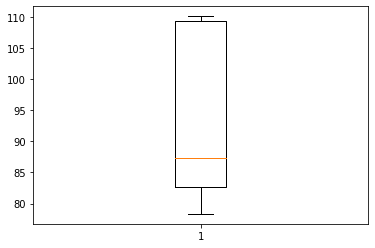

In [12]:
import matplotlib.pyplot as plt
plt.boxplot(mejores_fitnesses)
plt.show()